# Image Classification Challenge

In [40]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics

##################################################
# Params
##################################################

DATA_BASE_FOLDER = 'data'

# Dataset

The dataset contains 50k train + 10k validation images of 10 different categories ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot').

Each image is a 28x28 grayscale, and for simplicity here is flattened into a 784 dimensional vector.

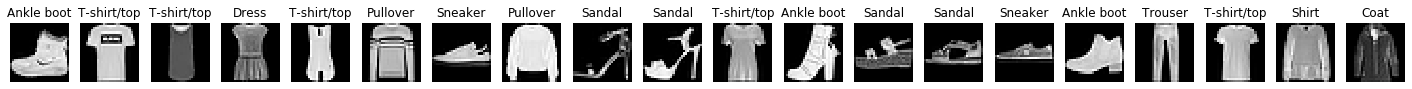

In [33]:
##################################################
# Load dataset
##################################################

x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [34]:
x_train.shape

(50000, 784)

In [35]:
##################################################
# Process the data here, if needed
##################################################

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train/255
x_valid_sc=x_valid/255

In [28]:
#to run only if you want to work with less data to speed up computation in experimental phase
size = 10000
x_train_sc=x_train_sc[0:size]
y_train=y_train[0:size]
x_valid_sc=x_valid_sc[0:size]
y_valid=y_valid[0:size]

# Model - SVM

Here you have to implement a model (or more models, for finding the most accurate) for classification.

You can use the [`sklearn`](https://scikit-learn.org/stable/) (or optionally other more advanced frameworks such as [`pytorch`](https://pytorch.org/) or [`tensorflow`](https://www.tensorflow.org/)) package that contains a pool of models already implemented that perform classification. (SVMs, NNs, LR, kNN, ...)

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## Grid search (cross validated) on a downsampled version of the dataset

In [8]:
# Define the grid for the grid search
Cs = np.power(2, np.asarray(list(range(4)))).tolist() # C = regularization parameter
gammas = np.power(1/2, np.asarray(list(range(6)))).tolist()[3:] # gamma: parameter for the RBF kernel

param_grid = [
    {'C': Cs, 'gamma': gammas, 'kernel': ['rbf']},
]

# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
print(param_grid)

[{'C': [1, 2, 4, 8], 'gamma': [0.125, 0.0625, 0.03125], 'kernel': ['rbf']}]


In [15]:
##################################################
# Implement you model here
##################################################

svc = SVC()
# grid search con 5 fold cross validation
clf = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1)
clf.fit(x_train_sc, y_train)

print(clf.best_params_)
print("Cross Validation Accuracy: %f" % clf.best_score_)

{'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}
Cross Validation Accuracy: 0.872500


In [17]:
# save the model to disk
filename = 'grid_search_svm_downsampled.sav'
joblib.dump(clf, filename)

['grid_search_svm_downsampled.sav']

In [18]:
clf.best_params_

{'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}

In [19]:
clf.score(x_valid_sc, y_valid)

0.8781

In [23]:
results_svm_gs = pd.DataFrame(clf.cv_results_)
results_svm_gs.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,237.260946,1.239280,27.493530,0.134380,1,0.125,rbf,"{'C': 1, 'gamma': 0.125, 'kernel': 'rbf'}",0.748503,0.735265,0.741871,0.748374,0.766032,0.7480,0.010245,12
1,128.451676,1.635109,21.844860,0.238880,1,0.0625,rbf,"{'C': 1, 'gamma': 0.0625, 'kernel': 'rbf'}",0.856287,0.838661,0.861431,0.847924,0.864729,0.8538,0.009461,8
2,66.187876,0.774719,18.151979,0.261955,1,0.03125,rbf,"{'C': 1, 'gamma': 0.03125, 'kernel': 'rbf'}",0.866267,0.851648,0.874937,0.863432,0.877255,0.8667,0.009128,4
3,240.696215,0.314167,27.755970,0.341017,2,0.125,rbf,"{'C': 2, 'gamma': 0.125, 'kernel': 'rbf'}",0.761477,0.745255,0.757879,0.764882,0.779559,0.7618,0.011079,9
4,138.407228,0.680498,22.266635,0.117981,2,0.0625,rbf,"{'C': 2, 'gamma': 0.0625, 'kernel': 'rbf'}",0.865269,0.841159,0.868434,0.855928,0.870741,0.8603,0.010822,5


## Train a single model with the best params with all the TS

In [42]:
#load already trained model if available

In [37]:
svm_final = SVC(C=4, gamma=0.03125, kernel='rbf')
svm_final.fit(x_train_sc, y_train)

SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.03125, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
svm_final.score(x_valid_sc, y_valid)

0.9039

In [39]:
# save the model to disk
filename = 'svm_model_fullTS.sav'
joblib.dump(svm_final, filename)

['svm_model_fullTS.sav']

In [ ]:
# confusion matrix
disp = metrics.plot_confusion_matrix(classifier, x_valid_n1, y_valid, normalize='all', include_values=False)